# Customised extension with `halomod`

In this tutorial, we use the existing infrastructure of `halomod` and plug in a new type of tracer, namely HI using the model from 2010.07985. This model requires three additions: a new density profile for HI; a new concentration-mass relation for HI; and finally a new HI HOD. Notice that you can also add a lot of other stuff into `halomod` as well, however, most likely you'll need to add something to build a new type of tracer, which is the case here.

Let's import a few basic things first:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from halomod import TracerHaloModel
import halomod
import hmf
import scipy

In [2]:
print("halomod version: ", halomod.__version__)
print("hmf version:", hmf.__version__)

halomod version:  1.4.6.dev71+gaca1ec0
hmf version: 3.1.0


## Creating a new density profile

The HI density profile used here is:

$$
\rho_{\rm HI} = \rho_s \bigg(\frac{r_s}{r}\bigg)^b {\rm exp}\bigg[-a \frac{r}{r_s}\bigg]
$$


Notice that all the infrastructure has been set up by `Profile` or `ProfileInf` class, depending on if you truncate the halos or not. And all you need to modify is the `_f` function, and optionally its integration `_h` and its Fourier transform `_p` (see documentation for [`profiles.py`](https://halomod.readthedocs.io/en/docs/_autosummary/halomod.profiles.html#module-halomod.profiles))

The `_f` function is:

$$
f(x) = \frac{1}{x^b}{\rm exp}\big[-ax\big]
$$

The integration in this case is:

$$
h = \Gamma(3-b)\times a^{b-3}
$$

where $\Gamma$ is the Gamma function

The Fourier Transformed profile is:

$$
p(K)= {\rm tan}^{-1}(K/a)/K,\,b=2
$$
$$
\begin{split}
p(K)=&\frac{-1}{1+(K/a)^2}\Bigg(\bigg(1+K^2/a^2\bigg)^{b/2}\times\\
&\Gamma(2-b)\sin\bigg[(b-2){\rm arctan}\big[K/a\big]\bigg]\Bigg),\,b\ne2
\end{split}
$$

In [3]:
from halomod.profiles import ProfileInf,Profile
from scipy.special import gamma

In [4]:
class PowerLawWithExpCut(ProfileInf):
    """
    A simple power law with exponential cut-off, 
    assuming f(x)=1/x**b * exp[-ax].
    """
    _defaults = {"a": 0.049, "b": 2.248}
    def _f(self, x):
        return 1. / (x**self.params['b']) * np.exp(-self.params['a']*x)

    def _h(self,c=None):
        return gamma(3-self.params['b']) * self.params['a']**(self.params['b']-3)

    def _p(self, K, c=None):
        b = self.params['b']
        a = self.params['a']
        if b==2:
            return np.arctan(K/a)/K
        else:
            return -1 / K * ((a**2+K**2)**(b/2-1)*gamma(2-b)*np.sin((b-2)*np.arctan(K/a)))

At bare minimum, you must specify `_f` which is just the density profile itself, and all the integration and Fourier transformation will be done numerically. However, that is very inefficient so you should always find analytical expression and specify if you can.

Now let's plug it into a halo model:

In [5]:
hm = TracerHaloModel(tracer_profile_model=PowerLawWithExpCut,
#                    tracer_profile_params={"a": 0.049, "b": 2.248}
                    )

And see the profile for a halo of mass $10^{10} M_\odot h^{-1}$ in Fourier space:

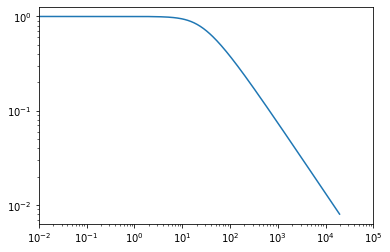

In [6]:
plt.plot(hm.k,hm.tracer_profile_ukm[:,1000]);
plt.xscale('log')
plt.yscale('log')
plt.xlim((1e-2,1e5));
#plt.ylim((1e-1,1))

And we've set up our profile model.

This profile model has 2 additional model parameters. You can always update these parameters using:

In [7]:
hm.tracer_profile_params = {"a": 0.049, "b": 2.248}

## Creating a new concentration-mass relation

The concentration-mass relation we use here follows the one from Maccio et al.(2007):

$$
c_{\rm HI}(M,z) = c_0 \Big(\frac{M}{10^{11}{\rm M_\odot h^{-1}}}\Big)^{-0.109}\frac{4}{(1+z)^\gamma}
$$

Again, because `halomod` already has a generic `CMRelation` class in place, all you really need is to specify a `cm` function for the equation above:

In [8]:
from halomod.concentration import CMRelation
from hmf.halos.mass_definitions import SOMean

In [9]:
class Maccio07(CMRelation):
    """
    HI concentration-mass relation based on Maccio et al.(2007). 
    Default value taken from 1611.06235.
    """
    _defaults = {'c_0': 28.65, "gamma": 1.45}
    native_mdefs = (SOMean(),)

    def cm(self,m,z):
        return self.params['c_0']*(m*10**(-11))**(-0.109)*4/(1+z)**self.params['gamma']

Note that for the concentration-mass relation that you put in, you need to specify the mass definition that this relation is defined in. In this case, it is defined in Spherical-Overdensity method, which is the default.

And construct our halo model with it:

In [10]:
hm = TracerHaloModel(tracer_concentration_model=Maccio07,
#                    tracer_concentration_params={'c_0': 28.65, "gamma": 1.45}
                    )

And check the concentration-mass relation at z=0:

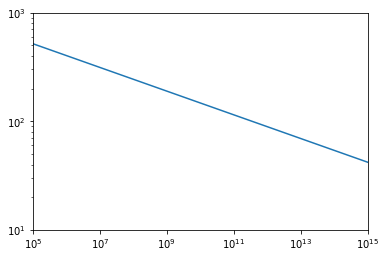

In [11]:
plt.plot(hm.m,hm.tracer_concentration.cm(hm.m,0))
plt.xscale('log')
plt.xlim(1e5,1e15)
plt.ylim((1e1,1e3))
plt.yscale('log');

Notice that this model has two additional parameters, which can be updated using:

In [12]:
hm.tracer_concentration_params={'c_0': 28.65, "gamma": 1.45}

See the documentation for [`concentration.py`](https://halomod.readthedocs.io/en/docs/_autosummary/halomod.concentration.html) for more.

## Creating a new HOD

The HI HOD we use here is:

$$
\begin{split}
\langle M_{\rm HI}^{\rm cen}(M_h) \rangle = M_h& \Bigg[a_1^{\rm cen}\bigg(\frac{M_h}{10^{10} M_\odot}\bigg)^{\beta_{\rm cen}} {\rm exp}\Big[{-\bigg(\frac{M_h}{M^{\rm cen}_{\rm break}}\bigg)^{\alpha_{\rm cen}}}\Big] \\&+a_2^{\rm cen}\Bigg] {\rm exp}\Big[{-\bigg(\frac{M_{\rm min}^{\rm cen}}{M_h}\bigg)^{0.5}}\Big]
\end{split}
$$

$$
\begin{split}
\langle M_{\rm HI}^{\rm sat}(M_h) \rangle = 
M_0^{\rm sat}\bigg( \frac{M_h}{M^{\rm sat}_{\rm min}}\bigg)^{\beta_{\rm sat}}
{\rm exp}\Big[{-\bigg(\frac{M^{\rm sat}_{\rm min}}{M_h}\bigg)^{\alpha_{\rm sat}}}\Big]
\end{split}
$$

For HOD, it's a bit more complicated. First, one need to decide what type of tracer it is. The most generic class to use is `HOD`, however, you may prefer `HODBulk` where the tracer is considered to be continuously distributed ; or `HODPoisson`, which assumes Poisson distributed discrete satellite components, which is commonly used for galaxies.

Second, if your model has a minimum halo mass to host any tracer as a sharp cut-off (or not), you need specify 

```python
sharp_cut = True # or False
```

If your model has a seperation of central and satellite components, you need to specify if the satellite occupation is inherently dependant on the existence of central galaxies:

```python
central_condition_inherent = False # or True
```

If False, the actual satellite component will be your satellite occupation times occupation for central galaxies.

See the documentation for [`hod.py`](https://halomod.readthedocs.io/en/docs/_autosummary/halomod.hod.html) for more.

Finally, you need to specify how to convert the unit between your HOD and the resulting power spectrum. For example, for HI the HOD is written in mass unit, whereas the power spectrum is in temperature unit. This is done by specifying a `unit_conversion` function

Additionally, sometimes your HOD contains function that need to be calculated, such as virial velocity of the halos, which you can just put into the class.

In [13]:
from halomod.hod import HODPoisson
import scipy.constants as const
import astropy.constants as astroconst

And in our case for utility, we also specify the number of galaxies in this model, which is defined by `_tracer_per_central` and `_tracer_per_satellite`:

In [14]:
class Spinelli19(HODPoisson):
    """
    Six-parameter model of Spinelli et al. (2019)
    Default is taken to be z=1(need to set it up manually via hm.update)
    """
    _defaults = {"a1": 0.0016,  # gives HI mass amplitude of the power law
                 "a2": 0.00011,  # gives HI mass amplitude of the power law
                 "alpha": 0.56,  # slop of exponential break
                 "beta": 0.43,  # slop of mass
                 "M_min": 9,  # Truncation Mass
                 "M_break": 11.86,  # Characteristic Mass
                 "M_1": -2.99,  # mass of exponential cutoff
                 "sigma_A": 0,  # The (constant) standard deviation of the tracer
                 "M_max": 18,  # Truncation mass
                 "M_0": 8.31, # Amplitude of satellite HOD
                 "M_break_sat": 11.4, # characteristic mass for satellite HOD
                 "alpha_sat": 0.84, # slop of exponential cut-off for satellite
                 "beta_sat": 1.10, # slop of mass for satellite
                 "M_1_counts": 12.851,
                 "alpha_counts": 1.049,
                 "M_min_counts": 11,  # Truncation Mass
                 "M_max_counts": 15,  # Truncation Mass
                 "a": 0.049,
                 "b": 2.248,
                 "eta": 1.0
                 }
    sharp_cut = False
    central_condition_inherent = False

    def _central_occupation(self, m):
        alpha = self.params['alpha']
        beta = self.params['beta']
        m_1 = 10 ** self.params['M_1']
        a1 = self.params['a1']
        a2 = self.params['a2']
        m_break = 10 ** self.params['M_break']

        out = m * (a1 * (m / 1e10) ** beta 
                   * np.exp(-(m / m_break) ** alpha) 
                   + a2) * np.exp(-(m_1 / m) ** 0.5)
        return out

    def _satellite_occupation(self, m):
        alpha = self.params['alpha_sat']
        beta = self.params['beta_sat']
        amp = 10 ** self.params['M_0']
        m1 = 10 ** self.params['M_break_sat']
        array = np.zeros_like(m)
        array[m >= 10 ** 11] = 1
        return amp * (m/m1) ** beta * np.exp(-(m1/m)**alpha) * array
        #return 10**8

    def unit_conversion(self, cosmo, z):
        "A factor (potentially with astropy units) to convert the total occupation to a desired unit."
        A12=2.869e-15
        nu21cm=1.42e9
        Const=(3.0*A12*const.h*const.c**3.0 )/(32.0*np.pi*(const.m_p+const.m_e)
                                               *const.Boltzmann * nu21cm**2);
        Mpcoverh_3=((astroconst.kpc.value*1e3)/(cosmo.H0.value/100.0))**3
        hubble = cosmo.H0.value * cosmo.efunc(z)*1.0e3/(astroconst.kpc.value*1e3)
        temp_conv=Const*((1.0+z)**2/hubble)
        # convert to Mpc^3, solar mass
        temp_conv=temp_conv/Mpcoverh_3 * astroconst.M_sun.value
        return temp_conv

    def _tracer_per_central(self, M):
        """Number of tracer per central tracer source"""
        n_c = np.zeros_like(M)
        n_c[
            np.logical_and(
                M >= 10 ** self.params["M_min_counts"],
                M <= 10 ** self.params["M_max_counts"],
            )
        ] = 1
        return n_c

    def _tracer_per_satellite(self, M):
        """Number of tracer per satellite tracer source"""
        n_s = np.zeros_like(M)
        index = np.logical_and(
            M >= 10 ** self.params["M_min_counts"],
            M <= 10 ** self.params["M_max_counts"],
        )
        n_s[index] = (M[index] / 10 ** self.params["M_1_counts"]) ** self.params[
            "alpha_counts"
        ]

        return n_s

And now update the halo model with this newly defined HOD:

In [15]:
hm=TracerHaloModel(hod_model=Spinelli19,
                  tracer_concentration_model=Maccio07,
                  tracer_profile_model=PowerLawWithExpCut
                  )

You can check out the mean density of this HI in solar mass over Mpc^3 unit:

In [16]:
hm.mean_tracer_den

128928553.08992167

And in temeperature unit:

In [17]:
hm.mean_tracer_den_unit

4.0534067588318536e-05

You can easily update the parameters using:

In [18]:
hm.update(hod_params={"beta": 1.0})

And to confirm it is indeed updated let's check the density again:

In [19]:
print(hm.mean_tracer_den)
print(hm.mean_tracer_den_unit)

887591333.7249895
0.0002790513524721072


And the power spectrum in length unit:

/home/ztchen/work/gitproject/halomod/src/halomod/halo_model.py:1285: RuntimeWarning: overflow encountered in double_scalars
  c[i] = tools.spline_integral(self.m, intg, xmin=10 ** mmin)


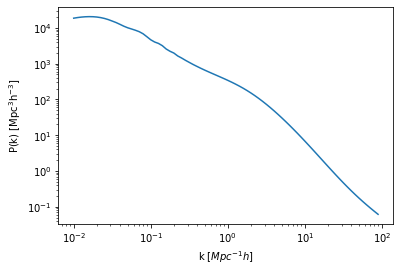

In [20]:
plt.plot(hm.k_hm, hm.power_auto_tracer)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm Mpc^3}h^{-3}]$");

And in temperature unit:

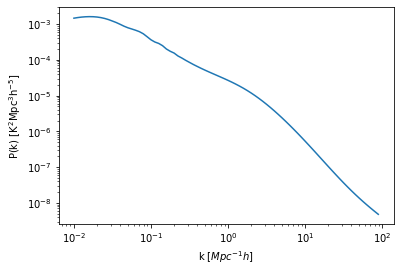

In [21]:
plt.plot(hm.k_hm, hm.power_auto_tracer*hm.mean_tracer_den_unit**2)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm K^2 Mpc^3}h^{-5}]$");

Following the release of v2.0.0, this set of HI halo model is added to `halomod`. To use it, simply call:

In [22]:
hm=TracerHaloModel(hod_model="Spinelli19",
                    tracer_concentration_model="Maccio07",
                    tracer_profile_model="PowerLawWithExpCut",
                    z=1 #for default value of hod parameters
                   )